# Exploring Oxford Nanopore DRS sequencing and alignment errors: TAIR10 error-corrected reads

Code for exploring the error rates observed in spike-in data from the ONT DRS datasets published in the paper *Native long-read RNA sequencing of the Arabidopsis thaliana transcriptome*. Here we're focussing on the ONT DRS reads, error corrected using Illumina data using (proovread)[https://github.com/BioInf-Wuerzburg/proovread], aligned to the TAIR10 genome with minimap2, for each of the four biological replicates of WT col-0 tissue.

Can proovread error-correct the data well? If so, how well? How do these results compare to the same plots for the non-error-corrected data?

In [1]:
import os, sys, pysam, numpy, json, matplotlib, re, time
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Datasets
import os, re
bam_files = {"col0_rep1":{"bamfile":"201901_col0_2916.error_corrected.bam",
                          "path":"../../error_corrected_datasets/alignments/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq"},
             "col0_rep2a":{"bamfile":"201903_col0_2917_exp2.error_corrected.bam",
                          "path":"../../error_corrected_datasets/alignments/20180405_FAH59362_WT_Col0_2917"},
             "col0_rep2b":{"bamfile":"201901_col0_2917.error_corrected.bam",
                          "path":"../../error_corrected_datasets/alignments/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917"},
             "col0_rep3":{"bamfile":"201901_col0_2918.error_corrected.bam",
                          "path":"../../error_corrected_datasets/alignments/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918"},
             "col0_rep4":{"bamfile":"201901_col0_2919.error_corrected.bam",
                          "path":"../../error_corrected_datasets/alignments/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919"},
             "col0_5padapter_rep1":{"bamfile":"201902_col0_2916_5adapter_exp2.error_corrected.bam",
                                    "path":"../../error_corrected_datasets/alignments/20180411_1432_20180911_FAH84603_5adapterLIG_Col0_2916"},
             "col0_5padapter_rep2":{"bamfile":"201902_col0_2918_5adapter.error_corrected.bam",
                                    "path":"../../error_corrected_datasets/alignments/20180508_1522_20180508_FAH82422_5adapt_lig_mRNA_2918"}}

bamfiles=[]
for keystr in bam_files.keys():
    fullpath = os.path.join(bam_files[keystr]["path"],
                            bam_files[keystr]["bamfile"])
    bamfiles.append(fullpath)

In [3]:
def getBestAlignments(bamfile):
    
    """Get the best alignment of each read - where best == longest"""
    
    best_alns={}
    rej_alns={}
    spikein_counts={}
    antisense_counts={}
    
    for readaln in bamfile.fetch():
        if not readaln.is_unmapped and readaln.seq is not None:
            isbest=True
            if readaln.query_name not in best_alns.keys():
                best_alns[readaln.query_name] = readaln
            elif readaln.alen > best_alns[readaln.query_name].alen:
                best_alns[readaln.query_name] = readaln
            else:
                isbest=False
                rej_alns[readaln.query_name] = readaln
            if isbest:
                thisref = bamfile.get_reference_name(readaln.reference_id)
                try:
                    spikein_counts[thisref]+=1
                except KeyError:
                    spikein_counts[thisref]=1
                if readaln.is_reverse:
                    try:
                        antisense_counts[thisref]+=1
                    except KeyError:
                        antisense_counts[thisref]=1
            
    return(best_alns, rej_alns, spikein_counts, antisense_counts)

In [4]:
# get the reads for our datasets
alignments={}
spikein_counts={}
antisense_counts={}
for bamfile in bamfiles:
    thisbam = pysam.AlignmentFile(bamfile, "rb")
    alns = getBestAlignments(thisbam)
    filename = os.path.basename(bamfile)
    print("{}:\n\tBest Alignments:\t{:>4d}\n\tRejected Alignments:\t{:>4d}".format(filename,
                                                                                   len(alns[0].keys()),
                                                                                   len(alns[1].keys())))
    alignments[os.path.basename(bamfile)]=alns[0]
    for refname in alns[2]:
        try:
            spikein_counts[refname]+=alns[2][refname]
        except KeyError:
            spikein_counts[refname]=alns[2][refname]
    for refname in alns[3]:
        try:
            antisense_counts[refname]+=alns[3][refname]
        except KeyError:
            antisense_counts[refname]=alns[3][refname]
    
print("\nDetected {} chromosomes with {} reads ({} antisense):\n".format(len(spikein_counts.keys()),
                                                                       sum(spikein_counts.values()),
                                                                       sum(antisense_counts.values())))
for refname in sorted(spikein_counts, key=spikein_counts.get, reverse=True):
    asc=0
    if refname in antisense_counts:
        asc=antisense_counts[refname]
    print("{}: {:>5d} ({:>5d})".format(refname, spikein_counts[refname], asc))

201901_col0_2916.error_corrected.bam:
	Best Alignments:	1024608
	Rejected Alignments:	3318
201903_col0_2917_exp2.error_corrected.bam:
	Best Alignments:	763375
	Rejected Alignments:	1745
201901_col0_2917.error_corrected.bam:
	Best Alignments:	955215
	Rejected Alignments:	1615
201901_col0_2918.error_corrected.bam:
	Best Alignments:	777570
	Rejected Alignments:	1147
201901_col0_2919.error_corrected.bam:
	Best Alignments:	782948
	Rejected Alignments:	2040
201902_col0_2916_5adapter_exp2.error_corrected.bam:
	Best Alignments:	359361
	Rejected Alignments:	 533
201902_col0_2918_5adapter.error_corrected.bam:
	Best Alignments:	581236
	Rejected Alignments:	1777

Detected 7 chromosomes with 5256500 reads (2743994 antisense):

1: 1576542 (810738)
5: 1029327 (515269)
3: 1009752 (526177)
2: 866028 (480259)
4: 765384 (407189)
Pt:  5936 ( 1935)
Mt:  3531 ( 2427)


In [5]:
def countBaseInstances(thisstr, updatedic):
    
    """ for a string count the a, t, g,& c's and update the dictionary"""

    bases = ["A","T","G","C","N"]
    thiscount = {"A":0,"T":0,"G":0,"C":0,"N":0}
    for base in bases:
        updatedic[base]+=thisstr.count(base)
        thiscount[base]+=thisstr.count(base)
    
    # sanity check
    if numpy.array(list(thiscount.values())).sum()!=len(thisstr):
        print(thiscount)
        raise ValueError("bases counted {} from string {} do not match string length {}".format(numpy.array(list(thiscount.values())).sum(),
                                                                                                thisstr,
                                                                                                len(thisstr)))
    
    return(updatedic)

def parseCStag(cstag, readseq):
    
    """Pases and extracts the identity and substitution information storred in a bam alignmnents cs flag
    
    See https://github.com/lh3/minimap2"""
    
    r = re.compile(":[0-9]+|\*[a-z][a-z]|[=\+\-][A-Za-z]+")
    csarr = numpy.array(r.findall(cstag))
    cs_stats = {"identity":0,
                "insertion":0,
                "deletion":0,
                "substitution":0,
                "refbases":""
                }
    
    cs_bpstats = {"insertion":{"A":0, "T":0, "C":0, "G":0, "N":0},
                  "deletion":{"A":0, "T":0, "C":0, "G":0, "N":0},
                  "substitution":{"A":[], "T":[], "C":[], "G":[], "N":[]},
                  "identity":{"A":0, "T":0, "C":0, "G":0, "N":0}}
    
    pos_in_read = 0
    for block in csarr:
        if block.startswith(":"):
            ilen = int(block.split(":")[1])
            cs_stats["identity"]+=ilen
            bases = readseq[pos_in_read:pos_in_read+ilen]
            pos_in_read+=ilen
            cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases)
            cs_bpstats["identity"] = countBaseInstances(bases, cs_bpstats["identity"])
        elif block.startswith("*"):
            bases = block.split("*")[1].upper()
            if len(bases)==2:
                cs_stats["substitution"]+=1
                cs_bpstats["substitution"][bases[0]].append(bases[1])
                cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases[0])
                pos_in_read+=1
            else:
                print(block)
        elif block.startswith("+"):
            bases = block.split("+")[1].upper()
            cs_stats["insertion"]+=len(bases)
            cs_bpstats["insertion"] = countBaseInstances(bases, cs_bpstats["insertion"])
            pos_in_read+=len(bases)
        elif block.startswith("-"):
            bases = block.split("-")[1].upper()
            cs_stats["deletion"]+=len(bases)
            cs_bpstats["deletion"] = countBaseInstances(bases, cs_bpstats["deletion"])
            cs_stats["refbases"] = "{}{}".format(cs_stats["refbases"], bases)
        else:
            print(block)
    
    #for key in cs_bpstats["substitution"].keys():
        #cs_bpstats["substitution"][key] = numpy.array(cs_bpstats["substitution"][key])
        
    return(cs_stats, cs_bpstats)

def getGlobalAlignmentStats(reads, nrep=100000):
    
    """Get a summary of the alignment stats for the reads based on the cs tags"""
    
    stats = {"matches":[],
             "insertion":[],
             "deletion":[],
             "skip":[],
             "softclip":[],
             "hardclip":[],
             "padding":[],
             "seqmatch":[],
             "seqmismatch":[],
             "back":[],
             "EditDist":[],
             "nbases":[],
             "nalignedbases":[]
            }
    
    stats["refbases"]={"A":0, "T":0, "C":0, "G":0, "N":0}
    stats["identity"]=[]
    stats["substitution"]=[]
    stats["bp_stats"]={"insertion":{"A":0, "T":0, "C":0, "G":0, "N":0},
                       "deletion":{"A":0, "T":0, "C":0, "G":0, "N":0},
                       "substitution":{"A":[], "T":[], "C":[], "G":[], "N":[]},
                       "identity":{"A":0, "T":0, "C":0, "G":0, "N":0}}
    
    i=0
    nc=1
    t0=time.time()
    #tprint=True
    for read in reads:
        try:
            # get cs tag info
            try:
                cs_stats, bp_stats = parseCStag(read.get_tag('cs'), read.seq)
            except:
                print(read)
                print(read.seq)
                raise
            
            # basic info
            stats["nbases"].append(read.query_length)
            stats["nalignedbases"].append(read.query_alignment_length)

            # sam cigar information
            read_cigar_stats = read.get_cigar_stats()[0]
            stats["matches"].append(read_cigar_stats[0])
            stats["insertion"].append(read_cigar_stats[1])
            stats["deletion"].append(read_cigar_stats[2])
            stats["skip"].append(read_cigar_stats[3])
            stats["softclip"].append(read_cigar_stats[4])
            stats["hardclip"].append(read_cigar_stats[5])
            stats["padding"].append(read_cigar_stats[6])
            stats["seqmatch"].append(read_cigar_stats[7])
            stats["seqmismatch"].append(read_cigar_stats[8])
            stats["back"].append(read_cigar_stats[9])
            stats["EditDist"].append(read_cigar_stats[10])
            
            
            # sanity checks:
            if cs_stats["insertion"]!=read_cigar_stats[1] or cs_stats["deletion"]!=read_cigar_stats[2] or (cs_stats["identity"]+cs_stats["substitution"])!=read_cigar_stats[0]:
                print(read.query_name)
                print("cs stats\n", cs_stats)
                print("cigar stats\n", read_cigar_stats)
                raise ValueError("cs flag information does not tally with sam cigar string information")
            else:
                stats["refbases"] = countBaseInstances(cs_stats["refbases"], stats["refbases"])
                stats["identity"].append(cs_stats["identity"])
                stats["substitution"].append(cs_stats["substitution"])
                #ta=time.time()
                for key in bp_stats.keys():
                    for base in bp_stats[key]:
                        if key=="substitution":
                            #print(key, base)
                            #print(i, stats["bp_stats"])
                            #print("x", bp_stats[key][base])
                            #print("type", type(stats["bp_stats"][key][base]))
                            #stats["bp_stats"][key][base] = numpy.append(stats["bp_stats"][key][base],bp_stats[key][base])
                            try:
                                stats["bp_stats"][key][base].extend(bp_stats[key][base])
                            except:
                                raise
                            #print(i, stats["bp_stats"])
                        else:
                            stats["bp_stats"][key][base]+=bp_stats[key][base]     
                #if tprint:
                    #print(stats["bp_stats"])
                #    print(time.time()-ta)
                #    tprint=False
            
        except KeyError:
            raise
        i+=1
        if i==nrep:
            print("\tprocessed {} reads in {:.2f}s ({} reads processed in total)".format(nrep,
                                                                                     time.time()-t0,
                                                                                     nc*nrep))
            nc+=1
            i=0
            t0=time.time()
            tprint=True
        
    for key in stats.keys():
        if key!="bp_stats" and key!="refbases":
            stats[key] = numpy.array(stats[key])
        elif key=="bp_stats":
            for base in stats["bp_stats"]["substitution"]:
                stats["bp_stats"]["substitution"][base] = numpy.array(stats["bp_stats"]["substitution"][base])
    
    return(stats)

In [6]:
# get the stats for our datasets
stats={}
for bamfile in alignments.keys():
    thisstats = getGlobalAlignmentStats(alignments[bamfile].values())
    stats[bamfile] = thisstats

	processed 100000 reads in 12.39s (100000 reads processed in total)
	processed 100000 reads in 10.92s (200000 reads processed in total)
	processed 100000 reads in 11.47s (300000 reads processed in total)
	processed 100000 reads in 11.49s (400000 reads processed in total)
	processed 100000 reads in 12.22s (500000 reads processed in total)
	processed 100000 reads in 12.58s (600000 reads processed in total)
	processed 100000 reads in 12.25s (700000 reads processed in total)
	processed 100000 reads in 12.51s (800000 reads processed in total)
	processed 100000 reads in 13.47s (900000 reads processed in total)
	processed 100000 reads in 12.89s (1000000 reads processed in total)
	processed 100000 reads in 12.41s (100000 reads processed in total)
	processed 100000 reads in 12.21s (200000 reads processed in total)
	processed 100000 reads in 11.87s (300000 reads processed in total)
	processed 100000 reads in 13.17s (400000 reads processed in total)
	processed 100000 reads in 12.72s (500000 reads

In [7]:
def getCS(datadic):
    
    """Get the combined stats accross all datasets"""
    
    def getICS(datadic, statkey, datasets):
        retarr=None
        for dataset in datasets:
            if retarr is None:
                retarr = datadic[dataset][statkey]
            else:
                retarr = numpy.append(retarr, datadic[dataset][statkey])
        return(retarr)
    
    datasets = sorted(list(datadic.keys()))
    ret_stats = {}
    refbases = None
    bpstats = None
    for statkey in datadic[datasets[0]].keys():
        if statkey=="refbases":
            for dataset in datasets:
                if refbases is None:
                    refbases = datadic[dataset]["refbases"]
                else:
                    for base in refbases.keys():
                        refbases[base] = refbases[base]+datadic[dataset]["refbases"][base]
        elif statkey=="bp_stats":
            for dataset in datasets:
                if bpstats is None:
                    bpstats = datadic[dataset]["bp_stats"]
                else:
                    for akey in bpstats.keys():
                        if akey == "substitution":
                            for base in bpstats["substitution"].keys():
                                bpstats["substitution"][base] = numpy.append(bpstats["substitution"][base],
                                                                             datadic[dataset]["bp_stats"]["substitution"][base])
                        else:
                            for base in bpstats[akey].keys():
                                bpstats[akey][base] = bpstats[akey][base] + datadic[dataset]["bp_stats"][akey][base]
        else:
            ret_stats[statkey] = getICS(datadic, statkey, datasets)
    
    ret_stats["refbases"]=refbases
    ret_stats["bp_stats"]=bpstats
    return(ret_stats)

In [8]:
aln_stats = getCS(stats)

# Plotting some of the global alignment accuracy distributions

Text(0.5, 0, 'fraction of aligned bases in read')

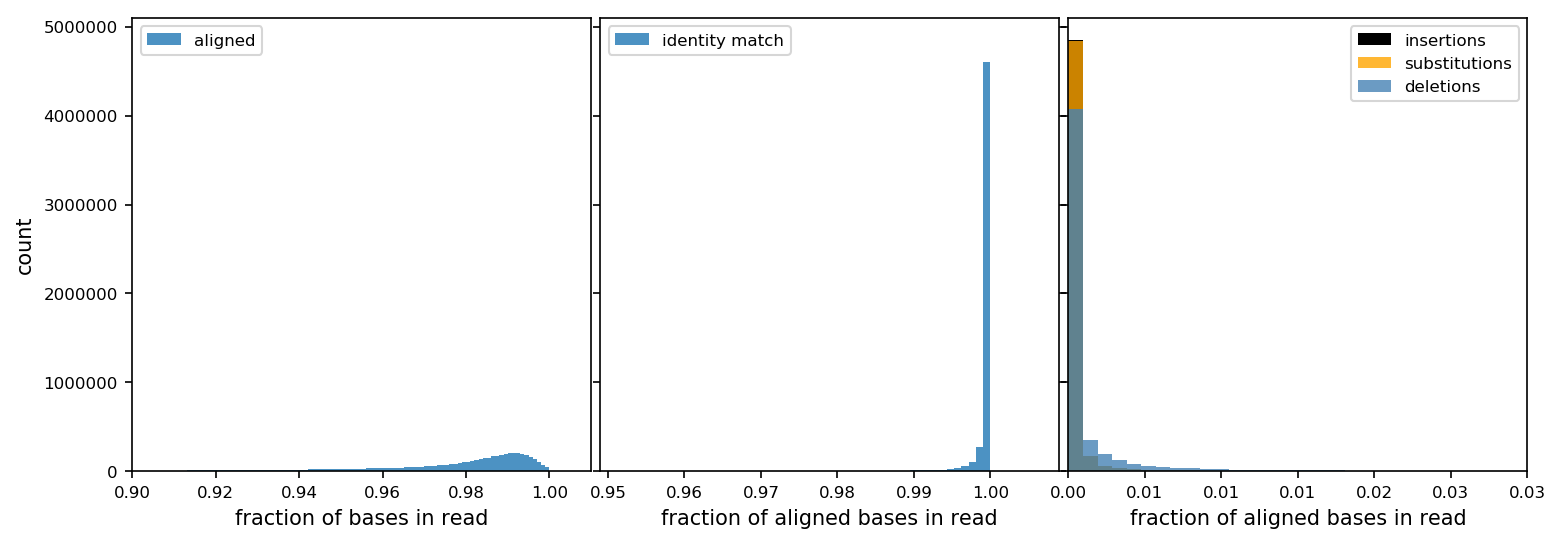

In [9]:
# Some plots.
labsize=8
bins=1000

fig = plt.figure(figsize=(12,4), dpi=150)
fig.subplots_adjust(wspace=0.02)
ax1=plt.subplot(131)
ax1.tick_params(axis='both', which='major', labelsize=labsize)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%i'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
x = plt.hist(aln_stats["nalignedbases"]/aln_stats["nbases"], bins=bins, alpha=0.8, label="aligned")
plt.xlim((0.9,1.01))
plt.xlabel("fraction of bases in read")
plt.legend(loc=2, fontsize=labsize)
plt.ylabel("count")
ax2=plt.subplot(132, sharey=ax1)
ax2.tick_params(axis='x', which='major', labelsize=labsize)
ax2.tick_params(axis='y', which='both', left=True, right=True, labelleft=False)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
y = plt.hist(aln_stats["identity"]/aln_stats["nalignedbases"], bins=bins, alpha=0.8,
             label="identity match")
plt.xlim((0.949,1.009))
plt.xlabel("fraction of aligned bases in read")
plt.legend(loc=2, fontsize=labsize)
#plt.ylabel("count")
ax3=plt.subplot(133, sharey=ax1)
ax3.tick_params(axis='x', which='major', labelsize=labsize)
ax3.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
x = plt.hist(aln_stats["insertion"]/aln_stats["nalignedbases"], bins=bins, label="insertions", color='black')
y = plt.hist(aln_stats["substitution"]/aln_stats["nalignedbases"], bins=x[1], alpha=0.8, label="substitutions", color='orange')
z = plt.hist(aln_stats["deletion"]/aln_stats["nalignedbases"], bins=x[1], alpha=0.8, label="deletions", color='steelblue')
plt.xlim((0.0,0.03))
plt.xlabel("fraction of aligned bases in read")
plt.legend(loc=1, fontsize=labsize)
plt.xlabel("fraction of aligned bases in read")

In [10]:
# So lets actually get a number for the accuracy of our data....
mean_alnfrac = (aln_stats["nalignedbases"]/aln_stats["nbases"]).mean()
stddev_alnfrac = (aln_stats["nalignedbases"]/aln_stats["nbases"]).std()
print("Mean alignment fraction: {:.2f} +{:.4f} -{:.4f}".format(mean_alnfrac*100,
                                                               100*2*stddev_alnfrac,
                                                               100*2*stddev_alnfrac))
mean_identity = (aln_stats["identity"]/aln_stats["nalignedbases"]).mean()
stddev_identity = (aln_stats["identity"]/aln_stats["nalignedbases"]).std()
print("Mean identity: {:.2f} +{:.4f} -{:.4f}".format(mean_identity*100,
                                                     100*2*stddev_identity,
                                                     100*2*stddev_identity))
mean_insertion = (aln_stats["insertion"]/aln_stats["nalignedbases"]).mean()
stddev_insertion = (aln_stats["insertion"]/aln_stats["nalignedbases"]).std()
print("Mean insertions: {:.2f} +{:.4f} -{:.4f}".format(mean_insertion*100,
                                                       100*2*stddev_insertion,
                                                       100*2*stddev_insertion))
mean_deletion = (aln_stats["deletion"]/aln_stats["nalignedbases"]).mean()
stddev_deletion = (aln_stats["deletion"]/aln_stats["nalignedbases"]).std()
print("Mean deletion: {:.2f} +{:.4f} -{:.4f}".format(mean_deletion*100,
                                                     100*2*stddev_deletion,
                                                     100*2*stddev_deletion))
mean_substitution = (aln_stats["substitution"]/aln_stats["nalignedbases"]).mean()
stddev_substitution = (aln_stats["substitution"]/aln_stats["nalignedbases"]).std()
print("Mean substitution: {:.2f} +{:.4f} -{:.4f}".format(mean_substitution*100,
                                                         100*2*stddev_substitution,
                                                         100*2*stddev_substitution))

Mean alignment fraction: 96.63 +12.2318 -12.2318
Mean identity: 99.87 +3.0777 -3.0777
Mean insertions: 0.08 +2.8465 -2.8465
Mean deletion: 0.17 +1.4709 -1.4709
Mean substitution: 0.05 +0.7120 -0.7120


# Enrichment of error types by base

Now lets look to see if the base distributions for each error category are random or match the sequence distributions We'l start by looking at the frations of insertions, substitutions and deletions by base (See http://onlinestatbook.com/2/estimation/proportion_ci.html).

In [11]:
print("Fractions of each base in the reference sequence underlying each read:")
proportions={"refbases":{},
             "bp_stats":{}}

for base in aln_stats["refbases"]:
    proportion = aln_stats["refbases"][base]/sum(aln_stats["refbases"].values())
    SE = numpy.sqrt((proportion*(1-proportion))/sum(aln_stats["refbases"].values()))
    CI = (1.96*SE) + (0.5/sum(aln_stats["refbases"].values()))
    proportions["refbases"][base] = {"proportion": proportion, "SE": SE, "95CI": CI}
    print("{}: {:.2f} +/-{:.2f} (95% CI)".format(base, proportion*100, CI*100))

for key in aln_stats["bp_stats"]:
    proportions["bp_stats"][key] = {}
    if key!="substitution":
        print("{} fractions relative to all {}s by (reference) base:".format(key, key))
        for base in aln_stats["bp_stats"][key].keys():
            proportion = aln_stats["bp_stats"][key][base]/sum(aln_stats["bp_stats"][key].values())
            SE = numpy.sqrt((proportion*(1-proportion))/sum(aln_stats["bp_stats"][key].values()))
            CI = (1.96*SE) + (0.5/sum(aln_stats["bp_stats"][key].values()))
            proportions["bp_stats"][key][base] = {"proportion": proportion, "SE": SE, "95CI": CI}
            print("{}: {:.2f} +/-{:.2f} (95% CI)".format(base, proportion*100, CI*100))
            
print("Substitution fractions relative to all substitutions by reference base:")
for base in aln_stats["bp_stats"]["substitution"].keys():
    proportion = len(aln_stats["bp_stats"]["substitution"][base])/aln_stats["substitution"].sum()
    SE = numpy.sqrt((proportion*(1-proportion))/aln_stats["substitution"].sum())
    CI = (1.96*SE) + (0.5/aln_stats["substitution"].sum())
    proportions["bp_stats"]["substitution"][base] = {"proportion": proportion, "SE": SE, "95CI": CI, "breakdown":{}}
    print("{}({:.2f} +/-{:.2f} 95% CI):".format(base, proportion*100, CI*100))
    baseto_unique, baseto_counts = numpy.unique(aln_stats["bp_stats"]["substitution"][base], return_counts=True)
    baseto_dict = dict(zip(baseto_unique, baseto_counts))
    proportions["bp_stats"]["substitution"][base]["breakdown"] = {}
    print("\tSubstitution fractions relative to all substitutions of reference base {}, by target base:".format(base))
    for baseto in baseto_dict:
        proportion = baseto_dict[baseto]/baseto_counts.sum()
        SE = numpy.sqrt((proportion*(1-proportion))/baseto_counts.sum())
        CI = (1.96*SE) + (0.5/baseto_counts.sum())
        proportions["bp_stats"]["substitution"][base]["breakdown"][baseto] = {"proportion": proportion, "SE": SE, "95CI": CI}
        print("\t{}: {:.2f} +/-{:.2f} (95% CI)".format(baseto, proportion*100, CI*100))

Fractions of each base in the reference sequence underlying each read:
A: 27.82 +/-0.00 (95% CI)
T: 28.01 +/-0.00 (95% CI)
C: 21.95 +/-0.00 (95% CI)
G: 22.22 +/-0.00 (95% CI)
N: 0.00 +/-0.00 (95% CI)
insertion fractions relative to all insertions by (reference) base:
A: 27.68 +/-0.04 (95% CI)
T: 27.04 +/-0.04 (95% CI)
C: 21.87 +/-0.04 (95% CI)
G: 23.41 +/-0.04 (95% CI)
N: 0.00 +/-0.00 (95% CI)
deletion fractions relative to all deletions by (reference) base:
A: 32.52 +/-0.03 (95% CI)
T: 32.30 +/-0.03 (95% CI)
C: 17.02 +/-0.03 (95% CI)
G: 18.16 +/-0.03 (95% CI)
N: 0.00 +/-0.00 (95% CI)
identity fractions relative to all identitys by (reference) base:
A: 27.81 +/-0.00 (95% CI)
T: 28.01 +/-0.00 (95% CI)
C: 21.96 +/-0.00 (95% CI)
G: 22.23 +/-0.00 (95% CI)
N: 0.00 +/-0.00 (95% CI)
Substitution fractions relative to all substitutions by reference base:
A(31.39 +/-0.06 95% CI):
	Substitution fractions relative to all substitutions of reference base A, by target base:
	C: 20.81 +/-0.09 (95% CI

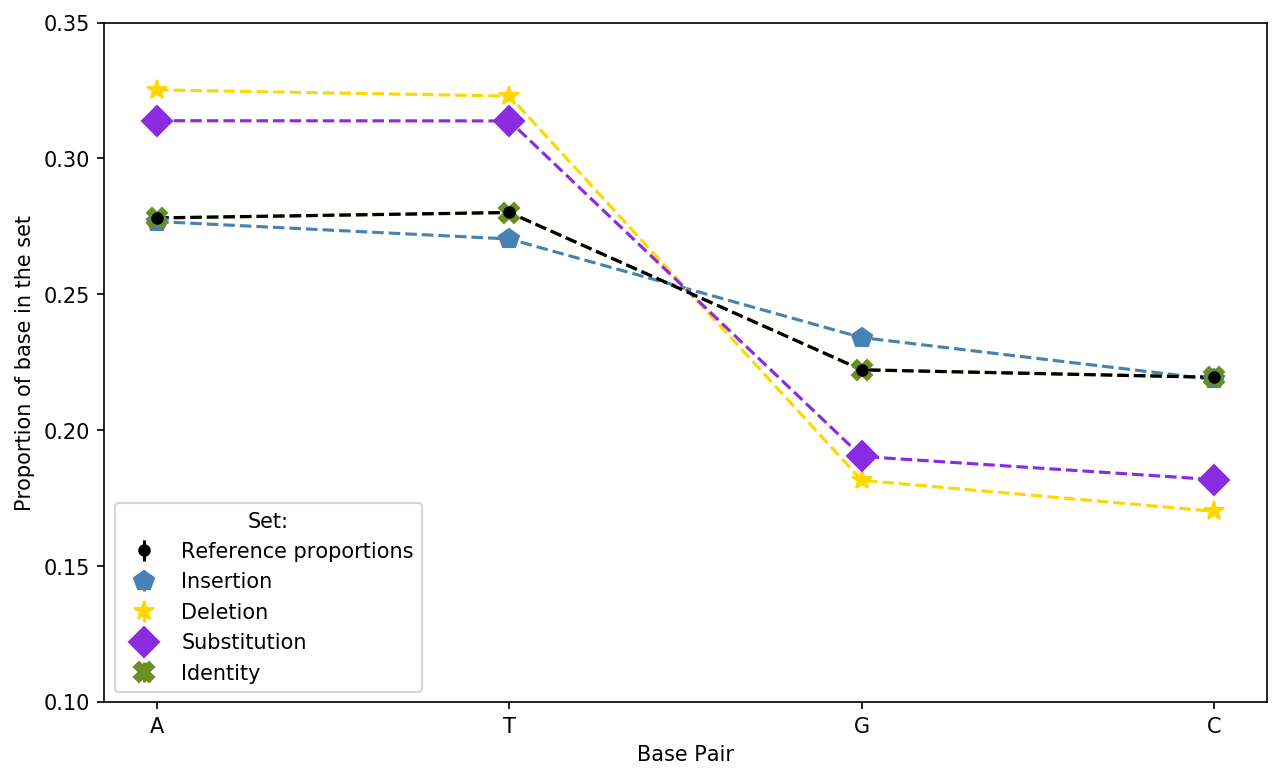

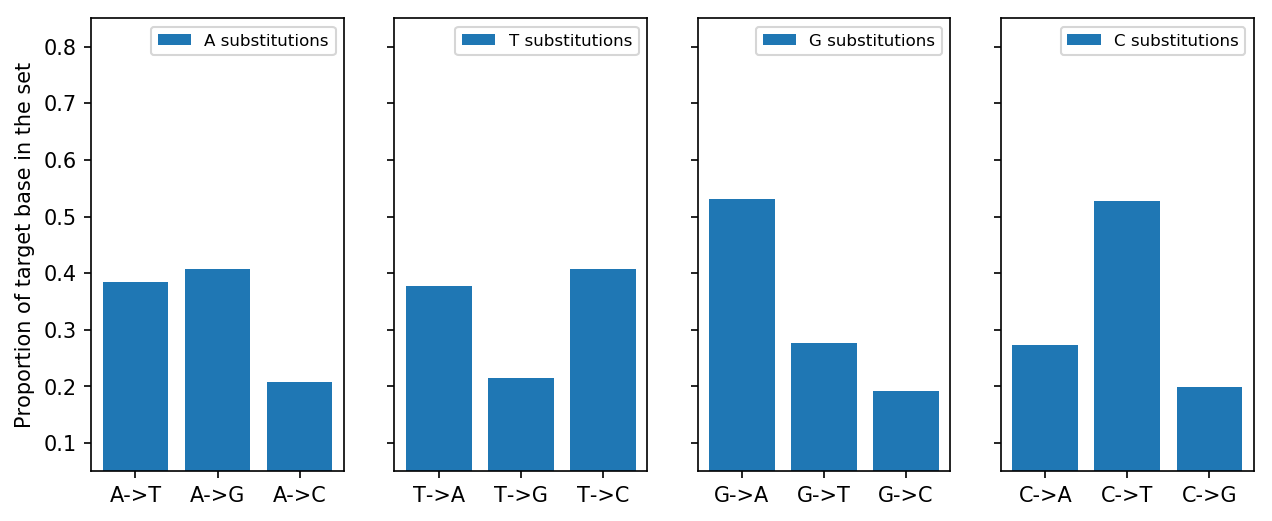

In [12]:
# Plot these proportions for each type of error. Here I'm going to use lines to highlight
# the different behaviours of the different errors...
bases = ["A","T","G","C"]
cols=['black', 'steelblue', 'gold', 'blueviolet', 'olivedrab']
markers = ['.','p','*','D','X']
markersize=10

fig = plt.figure(figsize=(10,6), dpi=150)
plotprops = []
ploterrors = []
for base in bases:
    plotprops.append(proportions['refbases'][base]["proportion"])
    ploterrors.append(proportions['refbases'][base]["95CI"])
refline = plt.plot(bases, plotprops, linestyle='--', zorder=2, color=cols[0])
refpoints = plt.errorbar(bases, plotprops, ploterrors, fmt="o", marker=markers[0],
                         markersize=markersize, label="Reference proportions", zorder=3, color=cols[0])

i=1
for key in proportions['bp_stats'].keys():
    plotprops = []
    ploterrors = []
    for base in bases:
        plotprops.append(proportions['bp_stats'][key][base]["proportion"])
        ploterrors.append(proportions['bp_stats'][key][base]["95CI"])
    thisline = plt.plot(bases, plotprops, linestyle='--', zorder=1, color=cols[i])
    thispoints = plt.errorbar(bases, plotprops, ploterrors, fmt="o", marker=markers[i],
                              markersize=markersize, label=key.capitalize(), zorder=2, color=cols[i])
    i+=1

plt.ylim((0.1,0.35))
plt.legend(title="Set:", loc=3, fontsize=10)
plt.xlabel("Base Pair")
plt.ylabel("Proportion of base in the set")

fig = plt.figure(figsize=(10,4), dpi=150)
x=141
p=None
for base in bases:
    if p is None:
        p = plt.subplot(x)
        ax = plt.gca()
        plt.ylabel("Proportion of target base in the set")
    else:
        ax = plt.subplot(x, sharey=p)
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plotbases = []
    plotprops = []
    ploterrors = []
    for baseto in bases:
        if baseto in proportions['bp_stats']["substitution"][base]["breakdown"].keys():
            plotbases.append("{}->{}".format(base, baseto))
            plotprops.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["proportion"])
            ploterrors.append(proportions['bp_stats']["substitution"][base]["breakdown"][baseto]["95CI"])
    plt.bar(plotbases, plotprops, label="{} substitutions".format(base.capitalize()))
    plt.ylim((0.05,0.85))
    x+=1
    plt.legend(loc=1, fontsize=8)

In [13]:
# OK lets use the g-test to see if these are geninely significantly different proportions
from scipy.stats import chisquare
ref_props = []
for base in sorted(list(aln_stats["refbases"].keys())):
    ref_props.append(proportions['refbases'][base]["proportion"])
ref_props = numpy.array(ref_props)
    
for key in aln_stats["bp_stats"]:
    key_counts=[]
    for base in sorted(list(aln_stats["refbases"].keys())):
        if key!="substitution":
            key_counts.append(aln_stats["bp_stats"][key][base])
        else:
            key_counts.append(len(aln_stats["bp_stats"]["substitution"][base]))
    
    key_counts = numpy.array(key_counts)
    print("pvalue for {} proportions different from the reference: {:.2e}".format(key, chisquare(key_counts, ref_props*key_counts.sum()).pvalue))

pvalue for insertion proportions different from the reference: 0.00e+00
pvalue for deletion proportions different from the reference: 0.00e+00
pvalue for substitution proportions different from the reference: 0.00e+00
pvalue for identity proportions different from the reference: 2.28e-138
